In [39]:
"""
Mean–variance portfolio optimization using real market data from Tiingo.
Optimal portfolio weights are estimated by maximizing the Sharpe ratio
under realistic allocation constraints.
"""


'\nMean–variance portfolio optimization using real market data from Tiingo.\nOptimal portfolio weights are estimated by maximizing the Sharpe ratio\nunder realistic allocation constraints.\n'

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from pandas_datareader import data as pdr
import requests

plt.style.use("seaborn-v0_8")


In [43]:
TIINGO_API_KEY = "2b3ebb7a9e20c5d3ae23195408f6f2ad0d7153d0"
HEADERS = {"Authorization": f"Token {TIINGO_API_KEY}"}


In [105]:
#Assets and Time Range
assets = {
    "MARKET": "SPY",
    "BANKS": "XLF",
    "TECH": "XLK",
    "FMCG": "XLP",
    "HEALTH": "XLV",
    "GOLD": "GLD"
}

start_date = "2016-01-01"
end_date = "2024-12-31"


In [47]:
def fetch_prices(ticker, start, end):
    url = f"https://api.tiingo.com/tiingo/daily/{ticker}/prices"
    params = {
        "startDate": start,
        "endDate": end,
        "format": "json"
    }
    r = requests.get(url, headers=HEADERS, params=params)
    data = pd.DataFrame(r.json())

    data["date"] = pd.to_datetime(data["date"])
    data.set_index("date", inplace=True)

    return data["adjClose"]


In [49]:
#Build Price Matrix
price_series = {}

for name, ticker in assets.items():
    s = fetch_prices(ticker, start_date, end_date)
    if not s.empty:
        price_series[name] = s

prices = pd.DataFrame(price_series)
prices = prices.dropna()

prices.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2264 entries, 2016-01-04 00:00:00+00:00 to 2024-12-31 00:00:00+00:00
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   MARKET  2264 non-null   float64
 1   BANKS   2264 non-null   float64
 2   TECH    2264 non-null   float64
 3   FMCG    2264 non-null   float64
 4   HEALTH  2264 non-null   float64
 5   GOLD    2264 non-null   float64
dtypes: float64(6)
memory usage: 123.8 KB


In [51]:
returns = np.log(prices / prices.shift(1)).dropna()


In [53]:
#Expected Returns & Covariance
mu = returns.mean() * 252
cov = returns.cov() * 252


In [55]:
#Risk-Free Rate
rf = pdr.DataReader("DTB3", "fred", start_date, end_date)
risk_free_rate = rf.mean().iloc[0] / 100


In [57]:
def portfolio_return(w):
    return w @ mu

def portfolio_volatility(w):
    return np.sqrt(w @ cov @ w)

def sharpe_ratio(w):
    return (portfolio_return(w) - risk_free_rate) / portfolio_volatility(w)


In [59]:
#Constraints and Bounds
n = len(mu)
w0 = np.ones(n) / n

constraints = [
    {"type": "eq", "fun": lambda w: np.sum(w) - 1},
    {"type": "ineq", "fun": lambda w: np.sum(w[:5]) - 0.60}
]

bounds = [(0, 0.30)] * 5 + [(0, 0.20)]


In [61]:
opt = minimize(
    lambda w: -sharpe_ratio(w),
    w0,
    method="SLSQP",
    bounds=bounds,
    constraints=constraints
)

opt.success


True

In [63]:
optimal_weights = pd.Series(opt.x, index=mu.index)
optimal_weights


MARKET    3.000000e-01
BANKS     2.393927e-02
TECH      3.000000e-01
FMCG      1.760607e-01
HEALTH    5.898060e-17
GOLD      2.000000e-01
dtype: float64

In [65]:
opt_return = portfolio_return(opt.x)
opt_vol = portfolio_volatility(opt.x)
opt_sharpe = sharpe_ratio(opt.x)

opt_return, opt_vol, opt_sharpe


(0.13706683228767835, 0.1503822970750568, 0.780676324526084)

In [67]:
#Efficient Frontier
target_returns = np.linspace(mu.min(), mu.max(), 40)
frontier_vol = []

for tr in target_returns:
    cons = constraints + [
        {"type": "eq", "fun": lambda w, tr=tr: portfolio_return(w) - tr}
    ]
    res = minimize(
        portfolio_volatility,
        w0,
        method="SLSQP",
        bounds=bounds,
        constraints=cons
    )
    frontier_vol.append(res.fun)


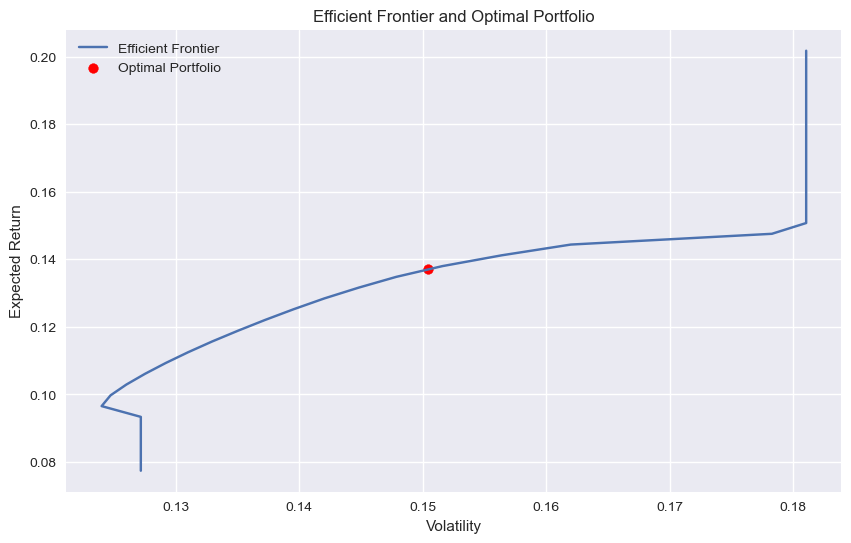

In [69]:
plt.figure(figsize=(10,6))
plt.plot(frontier_vol, target_returns, label="Efficient Frontier")
plt.scatter(opt_vol, opt_return, c="red", label="Optimal Portfolio")
plt.xlabel("Volatility")
plt.ylabel("Expected Return")
plt.title("Efficient Frontier and Optimal Portfolio")
plt.legend()
plt.show()

In [71]:
results = pd.DataFrame({
    "Weight": optimal_weights,
    "Expected Return": mu
})

results


,Weight,Expected Return
MARKET,3.000000e-01,0.136357
BANKS,2.393927e-02,0.123349
TECH,3.000000e-01,0.201717
FMCG,1.760607e-01,0.077426
HEALTH,5.898060e-17,0.090695
GOLD,2.000000e-01,0.095301


In [107]:
# Risk aversion coefficient
#Define Risk Aversion and Utility Levels
A = 4  

# Volatility range for plotting
sigma_range = np.linspace(min(frontier_vol)*0.9, max(frontier_vol)*1.05, 200)

# Utility levels chosen around optimal portfolio
U_star = opt_return - 0.5 * A * opt_vol**2
utility_levels = [U_star - 0.01, U_star, U_star + 0.01]

In [75]:
indifference_curves = []

for U in utility_levels:
    mu_curve = U + 0.5 * A * sigma_range**2
    indifference_curves.append(mu_curve)


In [ ]:
#Compute Indifference Curves

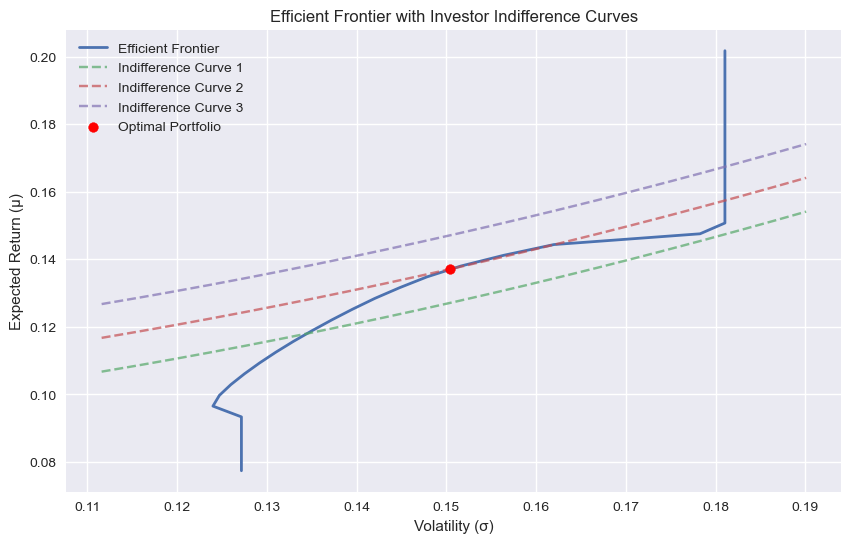

In [77]:
plt.figure(figsize=(10,6))

# Efficient frontier
plt.plot(frontier_vol, target_returns, label="Efficient Frontier", linewidth=2)

# Indifference curves
for i, mu_curve in enumerate(indifference_curves):
    plt.plot(
        sigma_range,
        mu_curve,
        linestyle="--",
        alpha=0.7,
        label=f"Indifference Curve {i+1}"
    )

# Optimal portfolio
plt.scatter(opt_vol, opt_return, color="red", zorder=5, label="Optimal Portfolio")

plt.xlabel("Volatility (σ)")
plt.ylabel("Expected Return (μ)")
plt.title("Efficient Frontier with Investor Indifference Curves")
plt.legend()
plt.show()


In [81]:
#Market-Implied Risk Aversion

In [83]:
# Market proxy statistics
mu_m = mu["MARKET"]
sigma_m = np.sqrt(cov.loc["MARKET", "MARKET"])

mu_m, sigma_m


(0.1363571498888895, 0.17903859351890977)

In [85]:
A_implied = (mu_m - risk_free_rate) / (sigma_m ** 2)
A_implied


3.6403331526502947

In [87]:
#Utility Level at Optimal Portfolio
U_star = opt_return - 0.5 * A_implied * opt_vol**2


In [89]:
sigma_range = np.linspace(min(frontier_vol)*0.9, max(frontier_vol)*1.05, 200)

utility_levels = [
    U_star - 0.01,
    U_star,
    U_star + 0.01
]

indifference_curves = []

for U in utility_levels:
    mu_curve = U + 0.5 * A_implied * sigma_range**2
    indifference_curves.append(mu_curve)


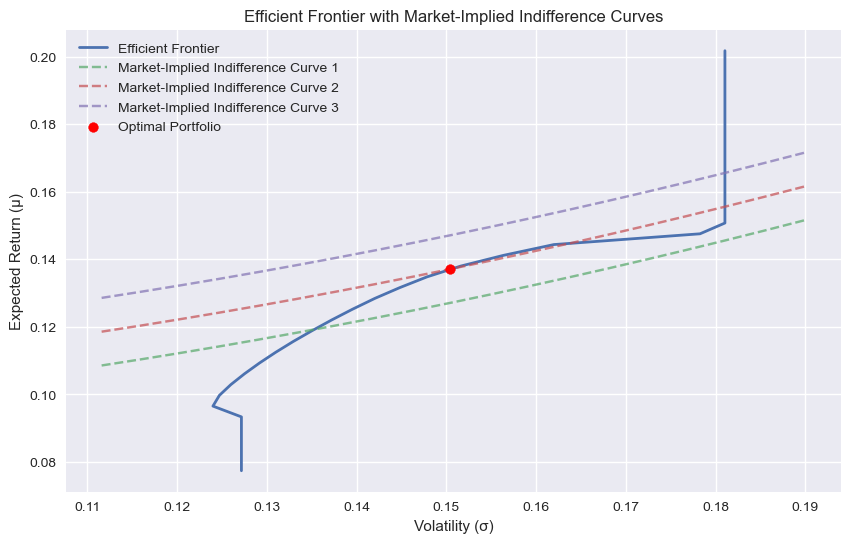

In [91]:
plt.figure(figsize=(10,6))

plt.plot(frontier_vol, target_returns, label="Efficient Frontier", linewidth=2)

for i, mu_curve in enumerate(indifference_curves):
    plt.plot(
        sigma_range,
        mu_curve,
        linestyle="--",
        alpha=0.7,
        label=f"Market-Implied Indifference Curve {i+1}"
    )

plt.scatter(opt_vol, opt_return, color="red", zorder=5, label="Optimal Portfolio")

plt.xlabel("Volatility (σ)")
plt.ylabel("Expected Return (μ)")
plt.title("Efficient Frontier with Market-Implied Indifference Curves")
plt.legend()
plt.show()


In [93]:
#Benchmark Dominance Test

In [95]:
benchmark_weights = np.ones(n) / n
benchmark_weights


array([0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667])

In [97]:
bench_return = portfolio_return(benchmark_weights)
bench_vol = portfolio_volatility(benchmark_weights)
bench_sharpe = (bench_return - risk_free_rate) / bench_vol

bench_return, bench_vol, bench_sharpe


(0.12080729529556081, 0.1443867711244245, 0.7004821922021536)

In [99]:
comparison = pd.DataFrame({
    "Optimized Portfolio": [opt_return, opt_vol, opt_sharpe],
    "Equal-Weight Benchmark": [bench_return, bench_vol, bench_sharpe]
}, index=["Expected Return", "Volatility", "Sharpe Ratio"])

comparison


,Optimized Portfolio,Equal-Weight Benchmark
Expected Return,0.137067,0.120807
Volatility,0.150382,0.144387
Sharpe Ratio,0.780676,0.700482


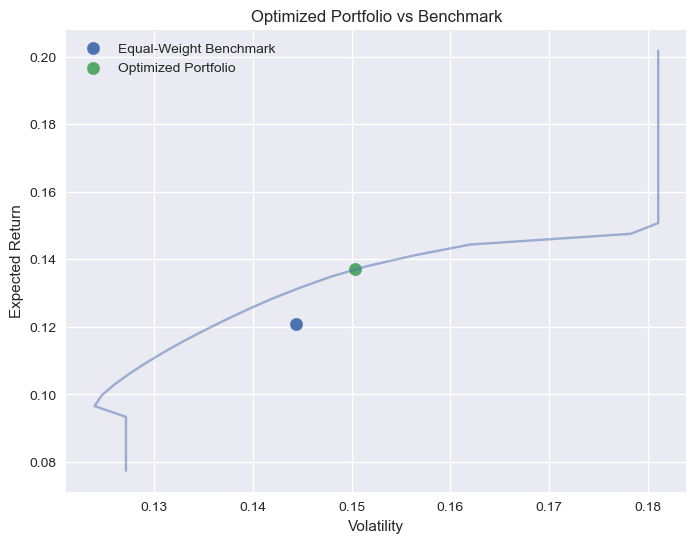

In [101]:
plt.figure(figsize=(8,6))

plt.scatter(bench_vol, bench_return, label="Equal-Weight Benchmark", s=80)
plt.scatter(opt_vol, opt_return, label="Optimized Portfolio", s=80)

plt.plot(frontier_vol, target_returns, alpha=0.5)

plt.xlabel("Volatility")
plt.ylabel("Expected Return")
plt.title("Optimized Portfolio vs Benchmark")
plt.legend()
plt.show()


In [103]:
import os

# Create results directory
results_dir = "results_Portfolio"
os.makedirs(results_dir, exist_ok=True)

# Save optimized weights
optimal_weights.to_csv(os.path.join(results_dir, "optimal_weights.csv"))

# Save benchmark comparison
comparison.to_csv(os.path.join(results_dir, "benchmark_comparison.csv"))

# Save key performance metrics
metrics = pd.DataFrame({
    "Optimized Portfolio": [opt_return, opt_vol, opt_sharpe],
    "Equal-Weight Benchmark": [bench_return, bench_vol, bench_sharpe]
}, index=["Expected Return", "Volatility", "Sharpe Ratio"])

metrics.to_csv(os.path.join(results_dir, "performance_metrics.csv"))

# Save Efficient Frontier plot
plt.figure(figsize=(10,6))
plt.plot(frontier_vol, target_returns, label="Efficient Frontier")
plt.scatter(opt_vol, opt_return, color="red", label="Optimal Portfolio")
plt.xlabel("Volatility")
plt.ylabel("Expected Return")
plt.title("Efficient Frontier and Optimal Portfolio")
plt.legend()
plt.savefig(os.path.join(results_dir, "efficient_frontier.png"), dpi=300)
plt.close()

# Save Indifference Curves plot
plt.figure(figsize=(10,6))
plt.plot(frontier_vol, target_returns, label="Efficient Frontier", linewidth=2)

for i, mu_curve in enumerate(indifference_curves):
    plt.plot(sigma_range, mu_curve, linestyle="--", alpha=0.7,
             label=f"Market-Implied Indifference Curve {i+1}")

plt.scatter(opt_vol, opt_return, color="red", zorder=5, label="Optimal Portfolio")
plt.xlabel("Volatility")
plt.ylabel("Expected Return")
plt.title("Efficient Frontier with Market-Implied Indifference Curves")
plt.legend()
plt.savefig(os.path.join(results_dir, "efficient_frontier_with_indifference_curves.png"), dpi=300)
plt.close()

print("All results saved to:", results_dir)


All results saved to: results_Portfolio
